# Захват, идентификация и отслеживание подвижных лиц на видео в реальном масштабе времени при помощи библиотеки face_recognition

In [ ]:
# импортируем необходимые библиотеки
!pip install face-recognition opencv-python pytube -q # Детектирования и классификация лиц, Работа с изображениями,
                                                      # Для скачивания видео YouTube (может не работать из-за политик YouTube)
!pip install pytube3 --upgrade -q
!pip install git+https://github.com/RiddlerQ/simple_image_download.git --no-deps # для скачивания изображений по запросу
                                                                                 # библиотека не работает под linux и в колабе
# установим зависимости simple_image_download вручную                            # --no-deps - флаг позволяет не скачивать ломающиеся зависимости
!pip install python-magic -q
!apt-get install -y libmagic-dev -q
!pip install progressbar -q

  Cloning https://github.com/RiddlerQ/simple_image_download.git to /tmp/pip-req-build-a_2tt5s7
  Running command git clone -q https://github.com/RiddlerQ/simple_image_download.git /tmp/pip-req-build-a_2tt5s7
  Created wheel for simple-image-download: filename=simple_image_download-0.4-cp37-none-any.whl size=4879 sha256=ee20a4d5c0b366963be483b3019fe950f1140f0421e7d7b203acecdc197624e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-ycxika4j/wheels/1b/bd/95/1d9de78b6746da52a97b7f8310292152fb6f04d94c7e95b355
Successfully built simple-image-download
Reading package lists...
Building dependency tree...
Reading state information...
libmagic-dev is already the newest version (1:5.32-2ubuntu0.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [ ]:
# Импорт необходимых библиотек
from tqdm.notebook import trange, tqdm
from pytube import YouTube

# Для обнаружения и идентификации лиц
import dlib
import face_recognition

# Работа с видео/изображениями
from shutil import copyfile
from simple_image_download import simple_image_download as simp
import matplotlib.pylab as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
from IPython.display import clear_output
import matplotlib.patches as patches
import os
import cv2
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
import seaborn as sns
import pandas as pd
import time
from collections import Counter, defaultdict
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
# Имена тех, чьи изображения нужно найти
actors = [
    'Павел Воля', 'Гарик Мартиросян', 'Гарик Харламов', 'Тимур Батрутдинов',
    'Таир Мамедов', 'Вадим Галыгин', 'Алексей Лихницкий', 'Роман Юнусов',
    'Тимур Родригез', 'Дмитрий Сорокин', 'Андрей Молочный', 'Антон Лирник'
]

# Эта папка создается автоматически
pathToDownload = 'simple_images'
response = simp.simple_image_download
NUMOFIMAGES = 50  # Сколько изображений нужно искать

# Здесь будут храниться размеченные изображения
pathToTrain = 'TRAIN'
if not os.path.exists(pathToTrain):
    os.makedirs(pathToTrain)

In [ ]:
print('Поиск и загрузка изображений:')
for name in tqdm(actors):
    response().download(name, NUMOFIMAGES)

Поиск и загрузка изображений:


In [ ]:
# Имена и количество найденных изображений
for name, num in zip(os.listdir(pathToDownload),[len(os.listdir(pathToDownload + '/' + folder)) for folder in os.listdir(pathToDownload)]):
    print(f'{name} : {num}')

Тимур_Родригез : 50
Тимур_Батрутдинов : 50
Андрей_Молочный : 50
Роман_Юнусов : 50
Вадим_Галыгин : 50
Гарик_Мартиросян : 50
Павел_Воля : 50
Гарик_Харламов : 50
Антон_Лирник : 50
Таир_Мамедов : 50
Дмитрий_Сорокин : 50
Алексей_Лихницкий : 50


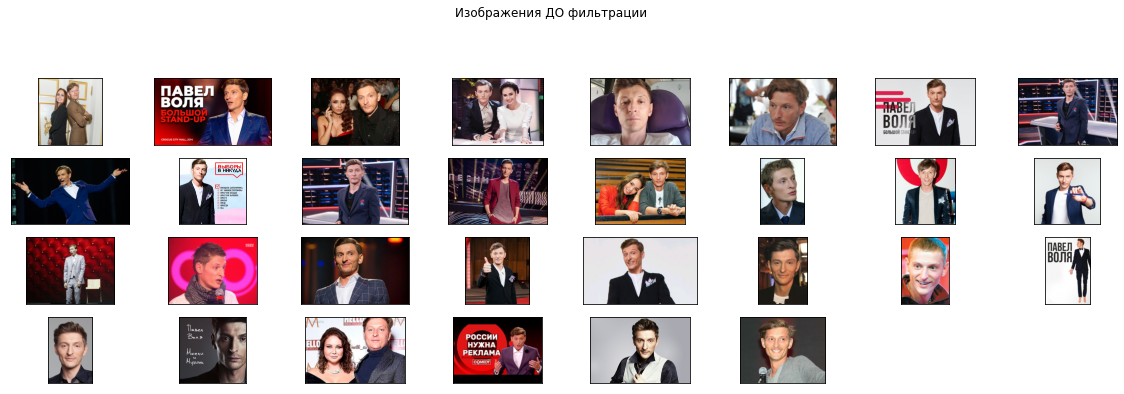

In [ ]:
# Выведем на экран найденные изображения

images = os.listdir(pathToDownload + '/' + 'Павел_Воля')

images = []
for image in os.listdir(pathToDownload + '/' + 'Павел_Воля'):
    images.append(
        mpimg.imread(pathToDownload + '/' + 'Павел_Воля' + '/' + image))

plt.figure(figsize=(20, 10)).suptitle('Изображения ДО фильтрации')
for i, image in enumerate(images[:30]):
    plt.subplot(len(images) / 8 + 1, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)

# plt.tight_layout()
plt.savefig('BEFORE.png', dpi = 300)
plt.show()

In [ ]:
def get_count_faces(imagePath):
    """
    Эта функция возвращает количество лиц, обнаруженных на изображении
    """

    image = face_recognition.load_image_file(imagePath)
    try:
        return len(face_recognition.face_encodings(image))
    except Exception as e:
        print(e)
        # ни одного
        return -1


print('Фильтрация обучающей выборки для последующего использования:')
for imageFolder in tqdm(os.listdir(pathToDownload)):
    for image in os.listdir(pathToDownload + '/' + imageFolder):
        # Если на изображении есть только одно лицо, то это, скорее всего, фотография нужного человека
        if get_count_faces(pathToDownload + '/' + imageFolder + '/' + image) == 1:
            # Создадим папку внутри цикла на случай, если
            # ни одно из изображений не будет пригодно для использования
            if not os.path.exists(pathToTrain + '/' + imageFolder):
                os.makedirs(pathToTrain + '/' + imageFolder)
            copyfile(pathToDownload + '/' + imageFolder + '/' + image,
                     pathToTrain + '/' + imageFolder + '/' + image)

Фильтрация обучающей выборки для последующего использования:


In [ ]:
# Имена и количество оставленных изображений
for name, num in zip(os.listdir(pathToTrain),[len(os.listdir(pathToTrain + '/' + folder)) for folder in os.listdir(pathToTrain)]):
    print(f'{name} : {num}')

Тимур_Родригез : 27
Тимур_Батрутдинов : 32
Андрей_Молочный : 28
Роман_Юнусов : 29
Вадим_Галыгин : 28
Гарик_Мартиросян : 35
Павел_Воля : 36
Гарик_Харламов : 30
Антон_Лирник : 34
Таир_Мамедов : 39
Дмитрий_Сорокин : 25
Алексей_Лихницкий : 33


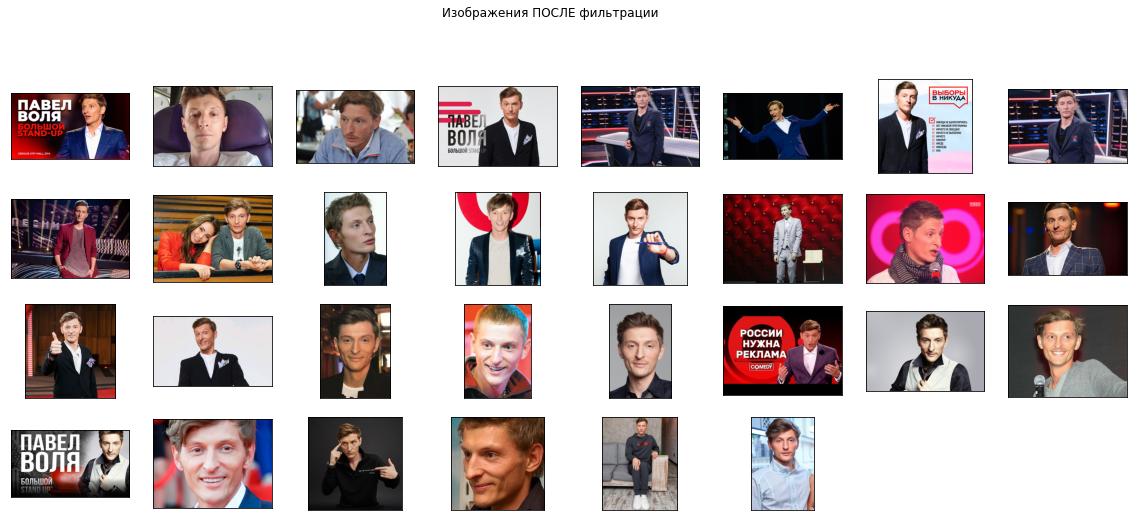

In [ ]:
# Отобразим изображения, оставшиеся для использования

images = os.listdir(pathToTrain + '/' + 'Павел_Воля')

images = []
for image in os.listdir(pathToTrain + '/' + 'Павел_Воля'):
    images.append(
        mpimg.imread(pathToTrain + '/' + 'Павел_Воля' + '/' + image))

plt.figure(figsize=(20, 10)).suptitle('Изображения ПОСЛЕ фильтрации')
for i, image in enumerate(images[:30]):
    plt.subplot(len(images) / 8 + 1, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)

# plt.tight_layout()
plt.savefig('AFTER.png', dpi = 300)
plt.show()

In [ ]:
# Кодируем лица как вектор с помощью библиотеки face_recognition
# (как слова, только лица)

NAMES, ENCODINGS = [], []
for imageFolder in tqdm(os.listdir(pathToTrain)):
    for image in os.listdir(pathToTrain + '/' + imageFolder):
        NAMES.append(imageFolder)
        image = face_recognition.load_image_file(pathToTrain + '/' + imageFolder + '/' + image)
        encoding = face_recognition.face_encodings(image)[0]
        ENCODINGS.append(encoding)


# проверям функцию предсказания 
print(imageFolder)
results = face_recognition.compare_faces(ENCODINGS, ENCODINGS[-1])
np.array(NAMES)[np.array(results) == True]


Алексей_Лихницкий


array(['Алексей_Лихницкий', 'Алексей_Лихницкий', 'Алексей_Лихницкий',
       'Алексей_Лихницкий', 'Алексей_Лихницкий', 'Алексей_Лихницкий',
       'Алексей_Лихницкий', 'Алексей_Лихницкий', 'Алексей_Лихницкий',
       'Алексей_Лихницкий', 'Алексей_Лихницкий', 'Алексей_Лихницкий',
       'Алексей_Лихницкий', 'Алексей_Лихницкий', 'Алексей_Лихницкий',
       'Алексей_Лихницкий', 'Алексей_Лихницкий', 'Алексей_Лихницкий',
       'Алексей_Лихницкий', 'Алексей_Лихницкий', 'Алексей_Лихницкий',
       'Алексей_Лихницкий', 'Алексей_Лихницкий', 'Алексей_Лихницкий',
       'Алексей_Лихницкий'], dtype='<U17')

In [ ]:
# Размерность вектора
ENCODINGS[-1].shape, np.array(ENCODINGS).shape

((128,), (376, 128))

[0.16480397 0.10653304]


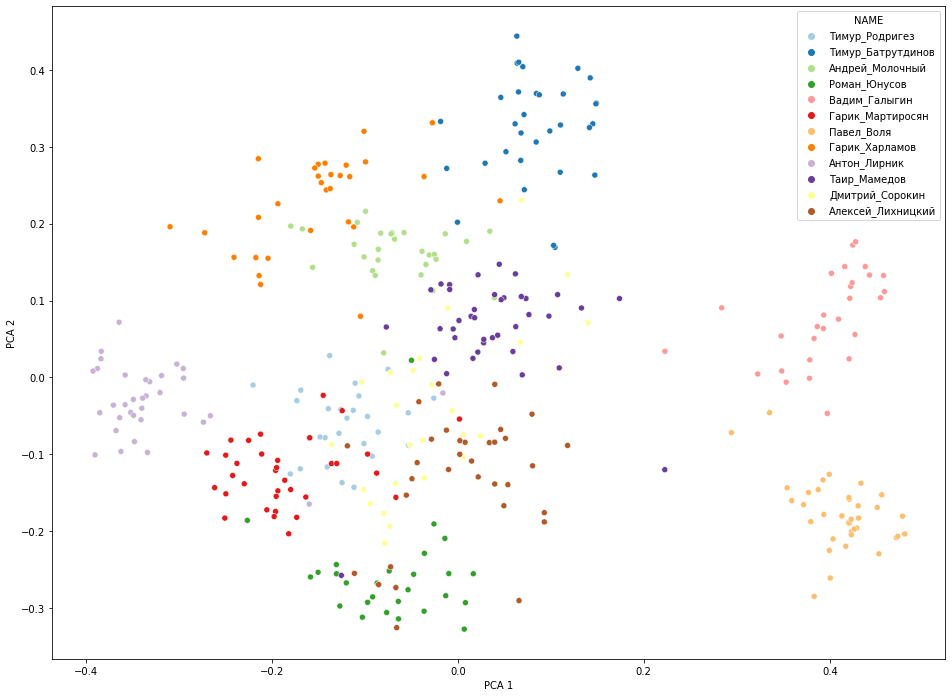

In [ ]:
# Проверим, как вектора лиц отображаются на графике, используя метод главных компонент для уменьшения размерности
pca = PCA(n_components=2)
pca2d = pca.fit_transform(np.array(ENCODINGS))
print(pca.explained_variance_ratio_)
data = pd.DataFrame(pca2d, columns=["PCA 1", "PCA 2"])
data['NAME'] = NAMES
plt.figure(figsize=(16, 12))
sns.scatterplot(data=data, x="PCA 1", y="PCA 2", hue='NAME', palette='Paired')
plt.savefig('PCA.png', dpi=300)

In [ ]:
# Проведем перекрестную проверку и обучим модель на полученных ранее векторах
TRAIN = np.array(ENCODINGS)
TARGET = NAMES


model = SVC(probability=True)
ovr = OneVsRestClassifier(model)
ovr.fit(TRAIN, TARGET)
print('Кросс-валидация: balanced_accuracy~averaged_f1')
print(np.mean(cross_val_score(ovr, TRAIN, TARGET, cv=3, scoring = 'balanced_accuracy')))
print(np.mean(cross_val_score(ovr, TRAIN, TARGET, cv=3, scoring = 'f1_macro')))

ovr.fit(TRAIN, TARGET)

Кросс-валидация: balanced_accuracy~averaged_f1
0.9474941724941726
0.9456192773240829


OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='rbf', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=None)

In [ ]:
print(TARGET[0])
ovr.predict(TRAIN[0,:].reshape(1, -1))

Тимур_Родригез


array(['Тимур_Родригез'], dtype='<U17')

In [ ]:
# Попытаемся загрузить какое-нибудь видео для распознавания лиц

# https://www.youtube.com/watch?v=xiNychrg-JI

# YouTube('https://www.youtube.com/watch?v=xiNychrg-JI').streams[0].download()

# ИЛИ yt1s.com <- online youtube video downloader
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1py7xe8iNJCdZYuOdVy75RfwIDKEPNG4c',
                                    dest_path='./VIDEO.zip')

!unzip VIDEO.zip

Archive:  VIDEO.zip
  inflating: TEST_720p.mp4           


In [ ]:
os.listdir()

['.config',
 'AFTER.png',
 'TRAIN',
 'PCA.png',
 'TEST_720p.mp4',
 'BEFORE.png',
 'VIDEO.zip',
 'simple_images',
 'sample_data']

Лиц детекстировано:  1


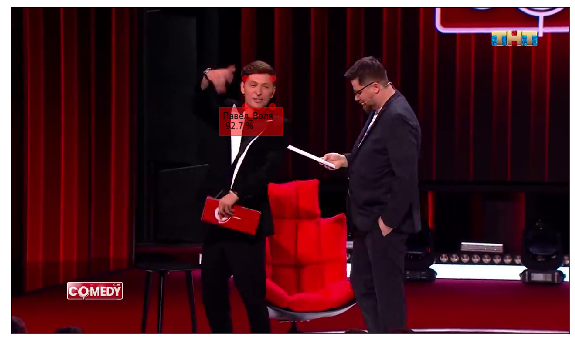

In [ ]:
# чем меньше размер тем быстрее рисует
plt.rcParams["figure.figsize"] = (10, 6)

# Загрузка видео
# Здесь также можно получить с устройства видео в реальном времени.
# Т.е. здесь видео в любом разрешении и любой продолжительности, mp4
video_capture = cv2.VideoCapture("TEST_720p.mp4")
frame_count = 0
# Отслеживание найденных лиц
TRACK = defaultdict(lambda: [])
STEP = 45 # Сколько кадров нужно пропустить перед повторным предсказанием
THRESH = 0.6
while video_capture.isOpened():

    ret, frame = video_capture.read()

    if not ret:
        video_capture.release()
        break

    frame_count += 1
    if frame_count % STEP == 0:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        plt.imshow(frame, interpolation='nearest', aspect='auto')
        plt.xticks([])
        plt.yticks([])

        rgb_frame = frame[:, :, ::-1]
        # Определяем лицевые характеристики
        face_locations = face_recognition.face_locations(rgb_frame)
        # Кодирование лиц на изображении в вектора
        faces = face_recognition.face_encodings(frame)

        print('Лиц детекстировано: ', len(faces))
        names = []
        for face, face_location in zip(faces, face_locations):

            name = ovr.predict(face.reshape(1, -1))
            prob = ovr.predict_proba(face.reshape(1, -1))[0]
            prob = prob[np.argmax(prob)]
            

            results = face_recognition.compare_faces(ENCODINGS, face)
            results = np.array(NAMES)[np.array(results) == True]
            L = len(results)
            if L > 0 and prob > THRESH:
                names.append(f"{name[0]} :\n {np.round(prob*100, 2)} %")
                results = results.tolist()
                c = [(c[0], c[1] / L) for c in Counter(results).most_common()]
                # Предсказание опорными векторами
                # print(names[-1])
                TRACK[name[0]].append(face_location)
                # Точный подсчёт
                # print(c)
            else:
                names.append(f"Неизвестный :\n Совпадение : {np.round(prob*100, 2)} %")

        for face_location, name in zip(face_locations, names):
            plt.plot(face_location[1], face_location[0], 'ro', alpha=0.5)
            plt.plot(face_location[1], face_location[2], 'ro', alpha=0.5)
            plt.plot(face_location[3], face_location[2], 'ro', alpha=0.5)
            plt.plot(face_location[3], face_location[0], 'ro', alpha=0.5)
            t = plt.text(face_location[3] - 50,
                         face_location[2] + 50,
                         name,
                         fontsize=8)
            t.set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='red'))

        #plt.savefig(f"{frame_count}.png", dpi = 300)
        plt.show()

        clear_output(wait=True)

In [ ]:
frame_count/=STEP

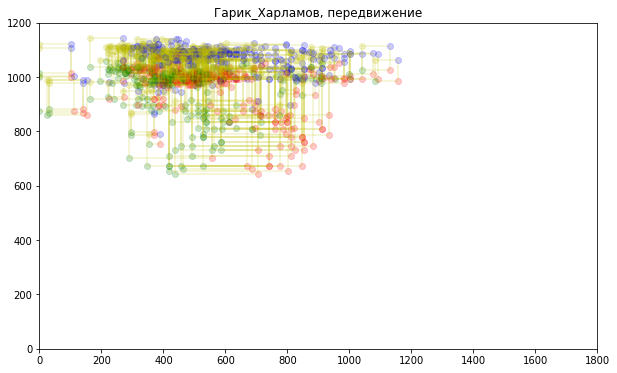

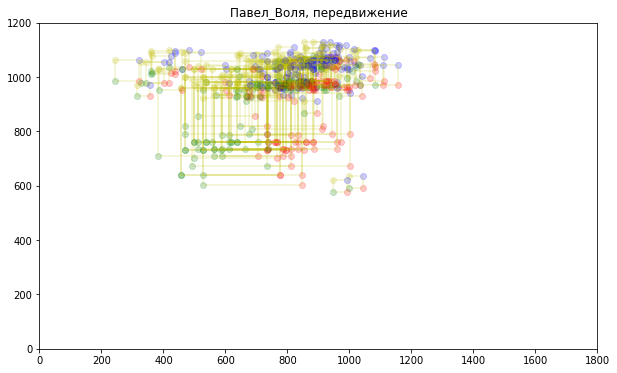

In [ ]:
# Зафиксируем размер кадра, чтобы можно было сравнить относительное положение объектов
XLIM, YLIM = 1800, 1200
for target, face_locations in TRACK.items():
    # Отфильтруем тех, кто появляется в кадре не менее 25% времени
    if len(face_locations) > (frame_count / 4):
        plt.figure(figsize=(10, 6))
        for face_location in face_locations:
            # Отобразим
            plt.plot(face_location[1],
                     YLIM - face_location[0],
                     'bo',
                     alpha=0.2)
            plt.plot(face_location[1],
                     YLIM - face_location[2],
                     'ro',
                     alpha=0.2)
            plt.plot(face_location[3],
                     YLIM - face_location[2],
                     'go',
                     alpha=0.2)
            plt.plot(face_location[3],
                     YLIM - face_location[0],
                     'yo',
                     alpha=0.2)
            plt.plot([
                face_location[3], face_location[3], face_location[1],
                face_location[1], face_location[3]
            ], [
                YLIM - face_location[0], YLIM - face_location[2],
                YLIM - face_location[2], YLIM - face_location[0],
                YLIM - face_location[0]
            ],
                'y',
                alpha=0.2)

        plt.title(f'{target}, передвижение')
        plt.ylim((0, YLIM))
        plt.xlim((0, XLIM))
        plt.savefig(f"MOVEMENT_{target}.png", dpi=300)
        plt.show()